In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import csv
from scipy.optimize import *
from numpy.lib.recfunctions import *
from utils import *
from data import *

In [3]:
x = x[lexsort((x['timestamp'], x['mmsi']))]
xorig = copy(x)

In [5]:
# Normalize speed and heading
speed = x['speed'] / 17.0
x['measure_speed'] = 1 - where(speed > 1.0, 1.0, speed)
x['measure_course'] = x['course'] / 360.0

windowSize = 3600

# Sort by mmsi, then by timestamp
x = x[lexsort((x['timestamp'], x['mmsi']))]

# Calculate rolling stddev/avg of course and speed
start_idx = 0
for end_idx in xrange(0, x.shape[0]):
    while (x['mmsi'][start_idx] != x['mmsi'][end_idx]
           or x['timestamp'][start_idx] < x['timestamp'][end_idx] - windowSize):
        start_idx += 1
    assert start_idx <= end_idx
    window = x[start_idx:end_idx + 1]   
    x['measure_speedstddev_3600'][end_idx] = window['measure_speed'].std()
    x['measure_speedavg_3600'][end_idx] = numpy.average(window['measure_speed'])
    x['measure_coursestddev_3600'][end_idx] = window['measure_course'].std()

    if isnan(x['measure_coursestddev_3600'][end_idx]):
        print "XXXXXX", start_idx, end_idx + 1

# Average with magic *2 scaling
score = (x['measure_coursestddev_3600'] + x['measure_speedstddev_3600'] + x['measure_speedavg_3600']) * 2.0 / 3.0

# Clamp to ]0, 1[
score = where(score < 0.0, 0.0, where(score > 1.0, 1.0, score))

# Port behavior is hard to distinguish from fishing, so supress score close to shore...
x['measure_new_score_3600'] = where(x['distance_to_shore'] < 3, 0.0, score)

Error for measure_new_score: 43.6246835357%
False positives for measure_new_score: 19.8366099894%
Error for measure_new_score: 43.6504068343%
False positives for measure_new_score: 19.8837634087%


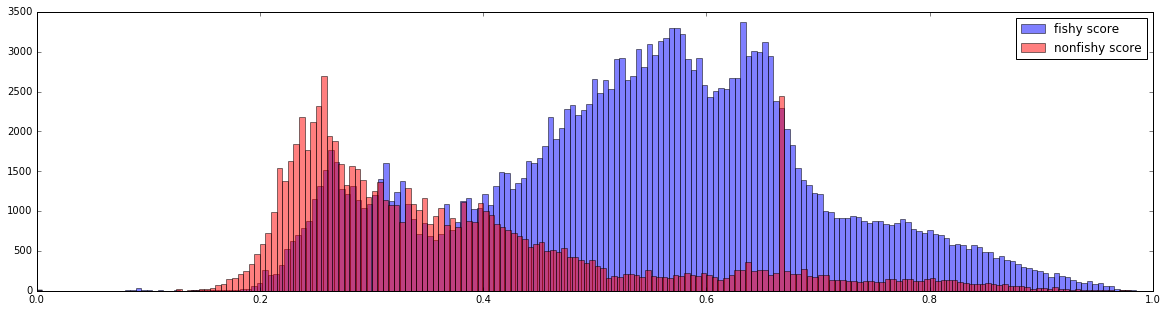

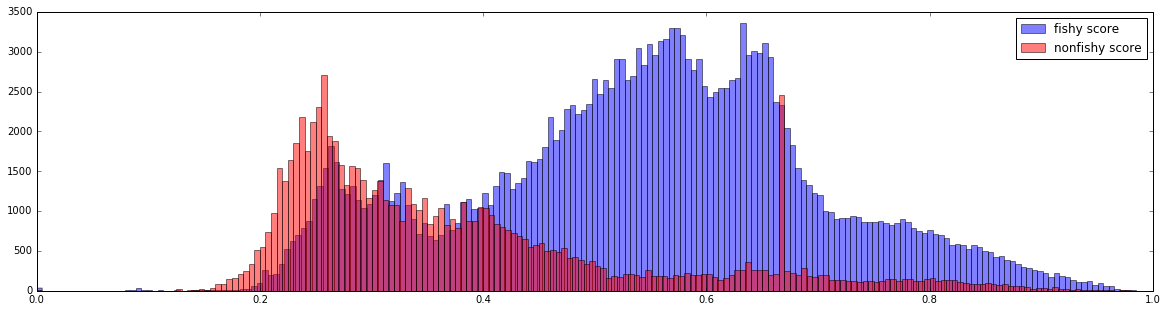

In [7]:
for a in (x, xorig):
    xfishy = fishy(a)
    xnonfishy = nonfishy(a)

    histfig = figure(figsize=(20,5))
    subplot = histfig.add_subplot(111)
    new_score_fishy = subplot.hist(xfishy["measure_new_score_3600"][xfishy['distance_to_shore'] > 3], bins=200, normed=False, color='b', alpha=0.5, label="fishy score")
    new_score_nonfishy = subplot.hist(xnonfishy["measure_new_score_3600"][xnonfishy['distance_to_shore'] > 3], bins=200, normed=False, color='r', alpha=0.5, label="nonfishy score")
    legend()

    total = sum(new_score_fishy[0] + new_score_nonfishy[0])
    non_overlap = sum(abs(new_score_fishy[0] - new_score_nonfishy[0]))
    overlap = total - non_overlap
    error = overlap / total

    print "Error for measure_new_score: %s%%" % (error * 100)

    cutoff = len(new_score_fishy[1][new_score_fishy[1] < 0.5])
    total = sum(new_score_fishy[0][cutoff:] + new_score_nonfishy[0][cutoff:])
    non_overlap = sum(abs(new_score_fishy[0][cutoff:] - new_score_nonfishy[0][cutoff:]))
    overlap = total - non_overlap
    error = overlap / total

    print "False positives for measure_new_score: %s%%" % (error * 100)
